# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [12]:
# Common libraries
import inspect
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import os

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

# Simulation functions
from sklearn.datasets import make_classification, make_blobs


# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Data
from sklearn.datasets import load_iris





In [13]:
# SETRED
import sys
sys.path.append(os.path.abspath(".."))
from setred_package import setred_scratch, simulated_data,  setred_scratch_v2
from utils.adspy_shared_utilities import plot_class_regions_for_classifier

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [14]:
# Parameters of the simulation
n = 13000  # Number of samples
K = 5      # Number of classes
p = 5     # Number of features

X = np.load("../data/X.npy")
y = np.load("../data/y.npy")
X_unlabel = np.load("../data/X_unlabel.npy")
y_unlabel = np.load("../data/y_unlabel.npy")
X_ori = np.load("../data/X_ori.npy")
y_ori = np.load("../data/y_ori.npy")
X_test = np.load("../data/X_test.npy")
y_test = np.load("../data/y_test.npy")

In [15]:
colors =    [ 
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
]

cmap_bold = ListedColormap(colors = colors)

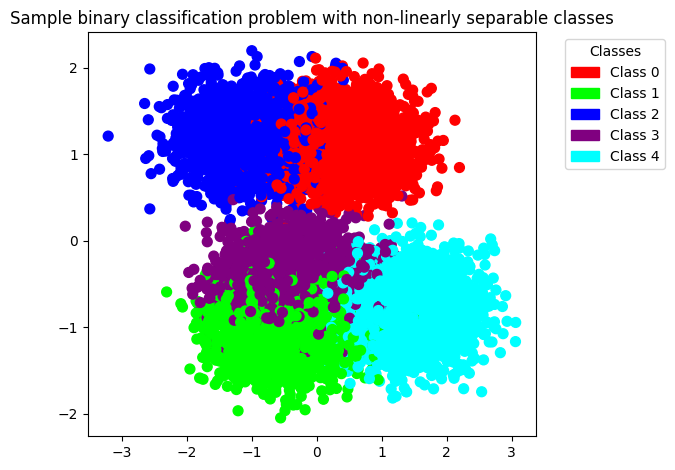

In [16]:
import matplotlib.patches as mpatches
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_ori)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Artificial semisupervised learning data


In [17]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the shape of the test datasets
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (9750, 5), y: (9750,), X_unlabel: (9702, 5), y_unlabel: (9702,)
Shape of X_test: (3250, 5), y_test: (3250,)
Frequencies of classes in y: -1    9702
 4      17
 1      12
 2       9
 3       7
 0       3
Name: count, dtype: int64


In [18]:
# Filtering the labeled instances
X_val = X[y != -1]
y_val = y[y != -1]
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (48, 5), y_val: (48,), X_test: (3250, 5), y_test: (3250,)
Frequencies of classes in y_val: 4    17
1    12
2     9
3     7
0     3
Name: count, dtype: int64
Frequencies of classes in y_test: 2    650
4    650
1    650
0    650
3    650
Name: count, dtype: int64


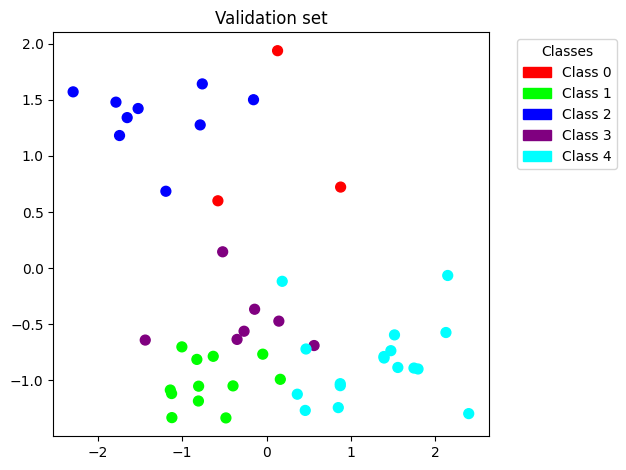

In [19]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


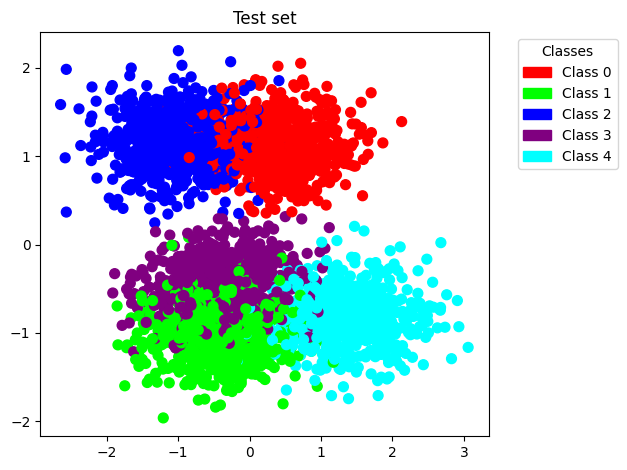

In [20]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_test)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/b9/3rhyw3yn6xj6wh63pjfz16100000gn/T/ipykernel_13388/1907776411.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_unlabel[:,0], X_unlabel[:,1], c='grey',


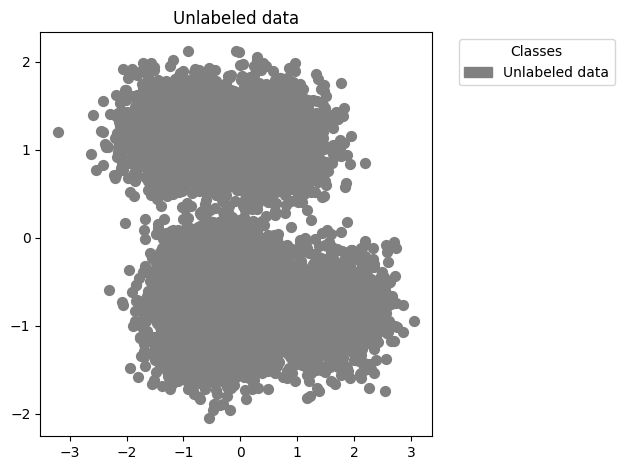

In [21]:
# plot unlabeled data
plt.figure()
plt.title('Unlabeled data')
plt.scatter(X_unlabel[:,0], X_unlabel[:,1], c='grey',
           marker= 'o', s=50, cmap=cmap_bold)
unique_classes = np.unique(y_unlabel)
patches = [mpatches.Patch(color='grey', label='Unlabeled data')]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# K nearest neighbours

In [23]:
knn = KNeighborsClassifier()
# Hyperparameters for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9,15,20],
    'weights': ['distance'],
    'p': [2],  # 1 = Manhattan, 2 = Euclidean
    'metric': ['euclidean']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_knn = KNeighborsClassifier(**best_params)
#base_estimator_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=20, p=2, weights='distance')
base_estimator_knn.fit(X_val, y_val)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

# Metrics of the base estimator

In [24]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_knn.predict(X_val)
y_test_pred = base_estimator_knn.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

Accuracy of the base estimator on the validation set: 1.0
Accuracy of the base estimator on the test set: 0.94
Classification report on validation set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        17

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       650
           1       1.00      0.99      0.99       650
           2       0.87      1.00      0.93       650
           3       0.91      0.94      0.92       650
           4       0.96      0.98      0.97       650

In [25]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_knn.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))

Accuracy of the base estimator on the unlabeled set: 0.9310451453308596
Classification report on unlabeled set:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      1947
           1       0.99      0.97      0.98      1938
           2       0.86      1.00      0.92      1941
           3       0.89      0.92      0.91      1943
           4       0.94      0.98      0.96      1933

    accuracy                           0.93      9702
   macro avg       0.94      0.93      0.93      9702
weighted avg       0.94      0.93      0.93      9702



In [26]:
from sklearn.metrics import  accuracy_score
accuracy_score(y_unlabel, y_unlabel_pred,sample_weight=None)

0.9310451453308596

# SETRED CLASSIFIER

In [27]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## KNN SETRED

In [28]:
ssl_clf_knn = setred_scratch.Setred_scratch(    
                            base_estimator=base_estimator_knn,
                            graph_neighbors=50,
                            max_iterations=40,                             
                            htunning=True,
                            param_grid={
                                        'n_neighbors': [ 2,5,7,10, 15, 20],
                                        'weights': ['distance', 'uniform'],
                                        'p': [2],  # 1 = Manhattan, 2 = Euclidean
                                        'metric': ['euclidean']
                                            },
                            X_test =X_test, # This is a matrix with the test instances to evaluate the model.
                            y_test=y_test,
                            y_real_label = y_unlabel,                            
                            view =10)
ssl_clf_knn.fit(X, y)


/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


---------------------------------------------------------------
-------------------Iteration 10 Started ------------
---------------------------------------------------------------
Distribution of predicted classes in the unlabeled set:
0     8
1     9
2    13
3    12
4     6
Name: count, dtype: int64
Distribution of real classes in the unlabeled set:
0    11
1     9
2    11
3    10
4     7
Name: count, dtype: int64
--------------------------------------------------------------
----------------------Simulation------------------------------
--------------------------------------------------------------
Simulation verification of the real labels of the unlabeled dataset
Iteration 10 - Accuracy: 0.9167
Iteration 10: Report of the base estimator 
:               precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       1.00      1.00      1.00         9
           2       0.85      1.00      0.92        11
           3       0.83     

Setred_scratch(X_test=array([[-0.77386801,  0.91393718,  0.45838719, -2.06331441, -1.88502076],
       [ 1.22601857, -0.23235781, -2.15052087,  0.30945195,  0.17721097],
       [ 0.08511313, -1.46941818,  0.57309643,  0.56057669,  0.76332383],
       ...,
       [ 0.8723636 , -0.84462254, -1.56126331,  0.10212189, -0.30338588],
       [-0.34049474, -0.40304738, -0.50286151, -0.43231011, -0.65014946],
       [-0.87596852,  0.81471607,  1.05536645, -1.36583667,  0.08124485]]),
               base_estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=3,
                                                   weights='distance'),
               graph_neighbors=50, htunning=True,
               param_grid={'metric': ['euclidean'],
                           'n_neighbors': [2, 5, 7, 10, 15, 20], 'p': [2],
                           'weights': ['distance', 'uniform']},
               view=10, y_real_label=array([4, 1, 4, ..., 4, 2, 0]),
               y_test=array([2, 4, 1, ..., 4, 3, 2]))

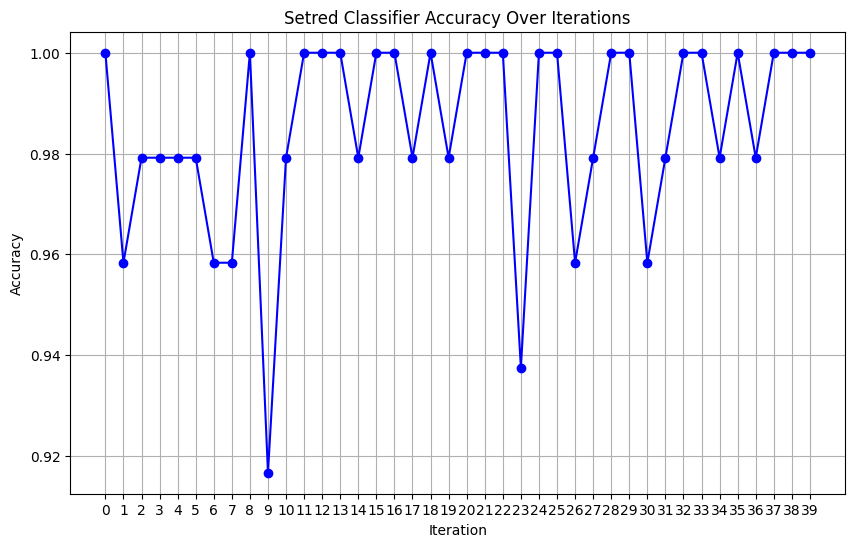

In [29]:
# Plot the accuracy of the Setred classifier
plt.figure(figsize=(10, 6))
plt.plot(ssl_clf_knn.accuracy_, marker='o', linestyle='-', color='b')
plt.title('Setred Classifier Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(len(ssl_clf_knn.accuracy_)))
plt.grid()


Text(0, 0.5, 'Feature 2')

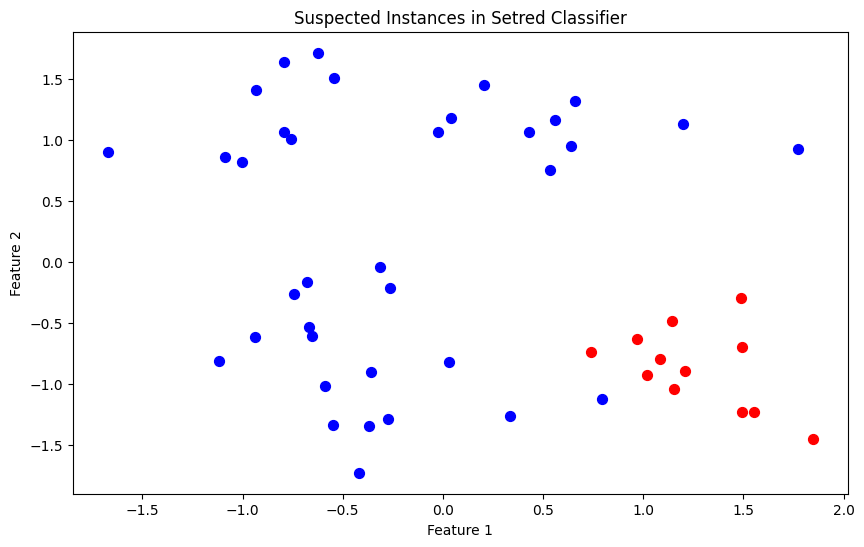

In [31]:
mask = ssl_clf_knn.yU_ == 4
x_suspect = ssl_clf_knn.XU_
y_suspect = ssl_clf_knn.yU_
plt.figure(figsize=(10, 6))
plt.scatter(x_suspect[mask, 0], x_suspect[mask, 1], c='red', label='Suspected Class 4', s=50)
plt.scatter(x_suspect[~mask, 0], x_suspect[~mask, 1], c='blue', label='Other Classes', s=50)
plt.title('Suspected Instances in Setred Classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


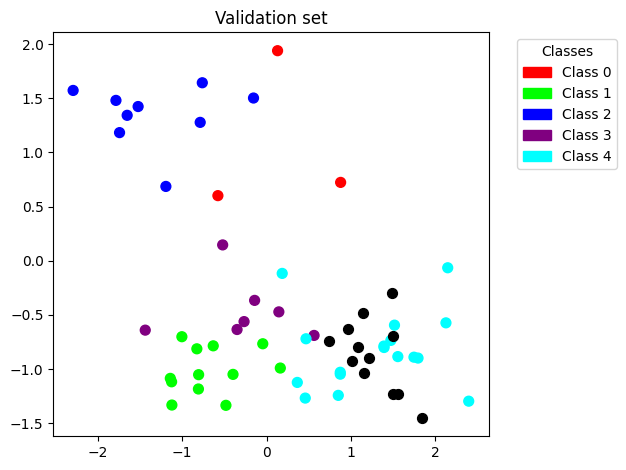

In [32]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
plt.scatter(x_suspect[mask, 0], x_suspect[mask, 1], c='black', label='Suspected Class 4', s=50)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

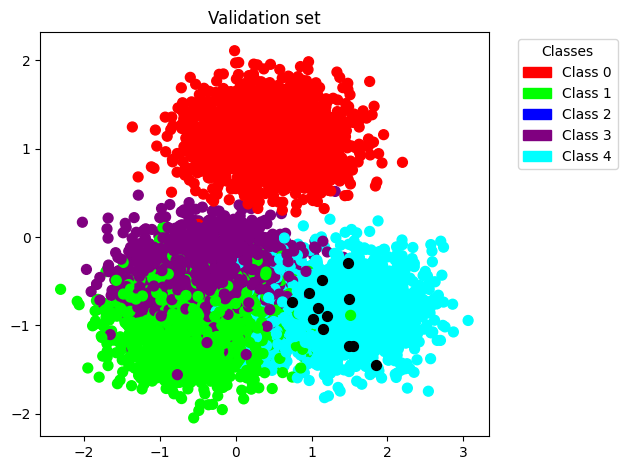

In [33]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_unlabel[y_unlabel!=2,0], X_unlabel[y_unlabel!=2,1], c=y_unlabel[y_unlabel!=2],
           marker= 'o', s=50, cmap=cmap_bold)
plt.scatter(x_suspect[mask, 0], x_suspect[mask, 1], c='black', label='Suspected Class 4', s=50)
unique_classes = np.unique(y_val)
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
# Show legend
plt.legend(handles=patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Simulation


In [37]:
# Simulation of the accuracy score
score = []
for i in range(100):
    # Fitting the Setred classifier
    ssl_clf_knn = setred_scratch.Setred_scratch(    
                                base_estimator=base_estimator_knn,
                                graph_neighbors=10,
                                max_iterations=40,                             
                                htunning=True,
                                param_grid={
                                            'n_neighbors': [ 2,5,7,10, 15, 20],
                                            'weights': ['distance', 'uniform'],
                                            'p': [2],  # 1 = Manhattan, 2 = Euclidean
                                            'metric': ['euclidean']
                                                },
                                X_test =X_test, # This is a matrix with the test instances to evaluate the model.
                                y_test=y_test,
                                y_real_label = y_unlabel,
                                messages=False,
                                view =5)
    ssl_clf_knn.fit(X, y)
    # Score
    score.append(ssl_clf_knn.score(X_test, y_test))

/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/jfjimenez09/anaconda3/envs/jfja_dissertation/lib/python3.11/site-

Accuracy score: 0.9695969230769234


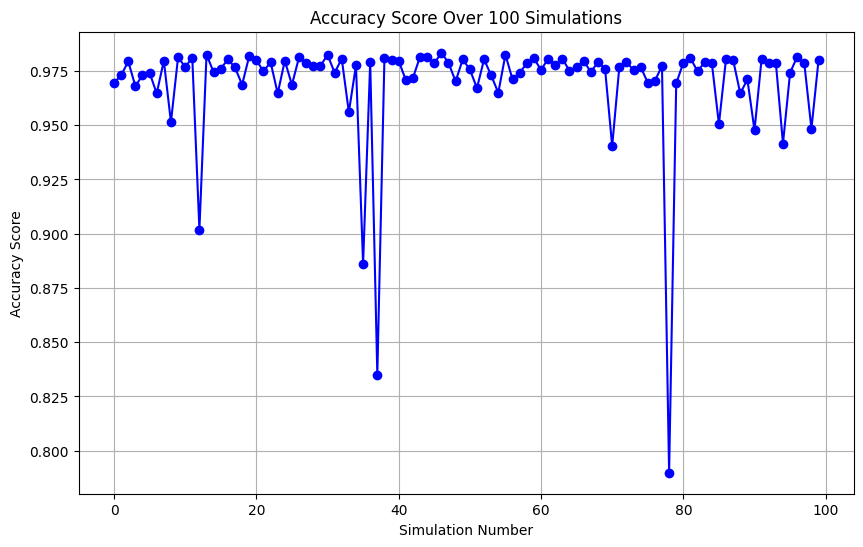

In [38]:
# Display the accuracy score
print(f"Accuracy score: {np.mean(score)}")
# Line plot 
plt.figure(figsize=(10, 6))
plt.plot(score, marker='o', linestyle='-', color='b')
plt.title('Accuracy Score Over 100 Simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Accuracy Score')
plt.grid()
plt.show()

# Evaluation metrics

In [34]:
# Generate predictions on the test set
y_pred = ssl_clf_knn.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       650
           1       0.99      0.99      0.99       650
           2       0.95      1.00      0.97       650
           3       0.97      0.97      0.97       650
           4       0.99      0.98      0.99       650

    accuracy                           0.98      3250
   macro avg       0.98      0.98      0.98      3250
weighted avg       0.98      0.98      0.98      3250



In [35]:
# Generate predictions on the test set
y_pred = base_estimator_knn.predict(X_test)
# Generate the classification report
print("Classification report on test set after Setred:")
report = classification_report(y_test, y_pred)
print(report)

Classification report on test set after Setred:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       650
           1       1.00      0.99      0.99       650
           2       0.87      1.00      0.93       650
           3       0.91      0.94      0.92       650
           4       0.96      0.98      0.97       650

    accuracy                           0.94      3250
   macro avg       0.94      0.94      0.94      3250
weighted avg       0.94      0.94      0.94      3250



## Acurracy comparison

In [36]:
# Comparison of the accuracy 
print("Accuracy of Setred classifier on the test set:", ssl_clf_knn.score(X_test, y_test))
print("Accuracy of base estimator on the test set:", base_estimator_knn.score(X_test, y_test))
# Difference
print("Difference in accuracy:", ssl_clf_knn.score(X_test, y_test) - base_estimator_knn.score(X_test, y_test))
# Percentage difference
percentage_difference = (ssl_clf_knn.score(X_test, y_test) - base_estimator_knn.score(X_test, y_test)) / base_estimator_knn.score(X_test, y_test) * 100
print(f"Percentage difference in accuracy: {percentage_difference:.2f}%")

Accuracy of Setred classifier on the test set: 0.9781538461538462
Accuracy of base estimator on the test set: 0.94
Difference in accuracy: 0.038153846153846205
Percentage difference in accuracy: 4.06%


In [ ]:
# Generate predictions on the test set
y_pred = ssl_clf_knn.predict(X_unlabel)

# Generate the classification report
report = classification_report(y_unlabel, y_pred)
print(report)

In [ ]:
# Generate predictions on the test set
y_pred = base_estimator_knn.predict(X_unlabel)

# Generate the classification report
report = classification_report(y_unlabel, y_pred)
print(report)

In [ ]:
ssl_clf_knn._base_estimator.n_neighbors

In [ ]:
base_estimator_knn.n_neighbors